## 02-Model

After cleaning the data, I started the process of building a model

To do that I first imported some libraries and read the cleaned version of the dataset from /data directory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "NASA"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

In [2]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")
        d = "/content/gdrive/MyDrive/datasets"
        if not os.path.isdir(d): os.makedirs(d)
        if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
    if COLAB:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
    else:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

In [3]:
target = f'{ROOT}/data/pc2.csv'
if os.path.isfile(target):
    print('Loading Local Copy...')


df = pd.read_csv(target)
print(df.shape)
df.head()

Loading Local Copy...
(1129, 38)


,Unnamed: 0,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defects
0,2,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.0,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0,False
1,3,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0,False
2,4,1.0,1.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,33.44,0.63,13.06,0.01,9.0,1.60,0.73,20.90,1.0,0.0,0.0,3.0,0.33,5.0,4.0,4.0,1.0,3.0,0.00,1.0,False
3,6,1.0,0.0,1.0,0.0,0.0,1.0,0.50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,10.87,3.50,133.19,0.01,11.0,0.29,7.40,38.05,1.0,0.0,0.0,2.0,0.33,4.0,7.0,4.0,7.0,3.0,50.00,2.0,False
4,7,3.0,1.0,1.0,0.0,6.0,2.0,1.00,2.0,3.0,1.0,0.5,5.0,1.0,0.0,1.0,1.0,11.07,4.38,211.89,0.02,14.0,0.23,11.77,48.43,0.5,2.0,3.0,5.0,0.50,5.0,9.0,4.0,7.0,4.0,50.00,2.0,False


As seen above, a new column formed which contains the indexes of the rows, I didn't need it so I dropped it

In [4]:
df=df.drop(df.columns[0], axis=1)
df.shape

(1129, 37)

In [5]:
df.head()

,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defects
0,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.0,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0,False
1,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0,False
2,1.0,1.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,33.44,0.63,13.06,0.01,9.0,1.60,0.73,20.90,1.0,0.0,0.0,3.0,0.33,5.0,4.0,4.0,1.0,3.0,0.00,1.0,False
3,1.0,0.0,1.0,0.0,0.0,1.0,0.50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,10.87,3.50,133.19,0.01,11.0,0.29,7.40,38.05,1.0,0.0,0.0,2.0,0.33,4.0,7.0,4.0,7.0,3.0,50.00,2.0,False
4,3.0,1.0,1.0,0.0,6.0,2.0,1.00,2.0,3.0,1.0,0.5,5.0,1.0,0.0,1.0,1.0,11.07,4.38,211.89,0.02,14.0,0.23,11.77,48.43,0.5,2.0,3.0,5.0,0.50,5.0,9.0,4.0,7.0,4.0,50.00,2.0,False


## Dataset Balancing

In [6]:
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
# https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688

The first thing I did was creating the avariables X and y

X variable contains all the features of df except for the target feature (defects)

y variable contains only the defects column

I also created a variable called model which contained the model I wanted to use which is Dicision Tree Classifier

In [7]:
X = df.iloc[:,:-1]
y = df['defects']
model = DecisionTreeClassifier()

Before building the model, I had to check the balance of the dataset

To do that, I checked the value count of y which holds the target feature

In [8]:
y.value_counts()

False    1115
True       14
Name: defects, dtype: int64

As seen above, the dataset is not balanced and this can have a negative effect on the model

To solved that issue I had to balance the dataset and I used the SMOTE technique to do so

In [9]:
# SMOTE

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
X.head()

,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL
0,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.0,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0
1,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,3.0,33.44,0.63,13.06,0.01,9.0,1.60,0.73,20.90,1.0,0.0,0.0,3.0,0.33,5.0,4.0,4.0,1.0,3.0,0.00,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.50,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,10.87,3.50,133.19,0.01,11.0,0.29,7.40,38.05,1.0,0.0,0.0,2.0,0.33,4.0,7.0,4.0,7.0,3.0,50.00,2.0
4,3.0,1.0,1.0,0.0,6.0,2.0,1.00,2.0,3.0,1.0,0.5,5.0,1.0,0.0,1.0,1.0,11.07,4.38,211.89,0.02,14.0,0.23,11.77,48.43,0.5,2.0,3.0,5.0,0.50,5.0,9.0,4.0,7.0,4.0,50.00,2.0


I then checked the value counts of the y variable again and now there is equal amount of True and False variables which means that the dataset is now balanced

I also noticed that I have more rows now in X and y and now the number of rows in X and y is 2230

In [10]:
y.value_counts()

False    1115
True     1115
Name: defects, dtype: int64

In [11]:
X.shape

(2230, 36)

## Features Importance & Model Building

I then started the process of model building

The first thing I did was fitting the X and y in the model

I then decided to check the feature importance. This  step can improve a model by preventing overfitting and only supplying the model with the features that have the highest scores

To do that I created a variable called importance and I used the function feature_importances from DecisionTreeClassifier to get an importance score of every feature

I then plotted the feature scores on a bar plot

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.06459
Feature: 2, Score: 0.00206
Feature: 3, Score: 0.17683
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00696
Feature: 7, Score: 0.03591
Feature: 8, Score: 0.12696
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00655
Feature: 11, Score: 0.04437
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.01244
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.01471
Feature: 16, Score: 0.00538
Feature: 17, Score: 0.12806
Feature: 18, Score: 0.00476
Feature: 19, Score: 0.04619
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.01628
Feature: 22, Score: 0.00488
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.01508
Feature: 25, Score: 0.01414
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.09824
Feature: 29, Score: 0.00420
Feature: 30, Score: 0.07900
Feature: 31, Score: 0.05459
Feature: 32, Score: 0.01991
Feature: 33, Score: 0.00012
Feature: 34, Score: 0.01157
Feature: 35, Score: 0.00623


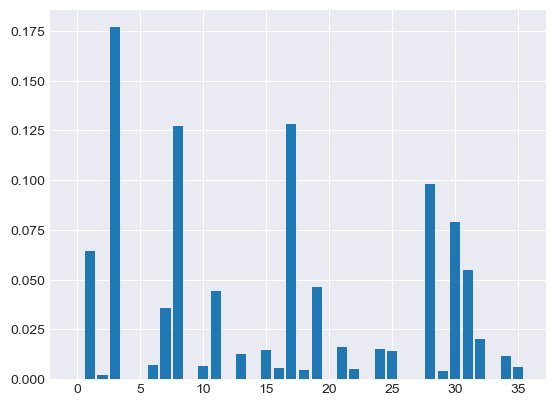

In [12]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

model.fit(X, y)

importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [13]:
print(X.columns[3])
print(X.columns[17])
print(X.columns[8])
print(X.columns[28])
print(X.columns[30])

LOC_COMMENTS
HALSTEAD_DIFFICULTY
DECISION_DENSITY
NORMALIZED_CYLOMATIC_COMPLEXITY
NUM_OPERATORS


As seen above, the most important features are 3 (LOC_COMMENTS), 17 (HALSTEAD_DIFFICULTY), 8 (DECISION_DENSITY), 28 (NORMALIZED_CYLOMATIC_COMPLEXITY) and 30 (NUM_OPERATORS)

I then decided to get the precision and recall scores of the model

To do that I had to use Cross Validation technique instead of the train test split technique  because the number of cases we have is small

I used StratifiedKFold and created 10 folds

I then created precision variable which contains the precision scores of every fold and recall variable which contains the recall scores of every fold

In [14]:
# https://stackoverflow.com/questions/27357121/scikit-calculate-precision-and-recall-using-cross-val-score-function

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
precision = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1)
recall = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)

In [15]:
precision

array([0.96460177, 0.97321429, 0.95652174, 0.99090909, 0.94017094,
       0.96396396, 0.97345133, 0.95575221, 0.97345133, 0.93965517])

In [16]:
recall

array([0.98198198, 0.98198198, 0.99099099, 0.98198198, 0.99099099,
       0.95535714, 0.99107143, 0.96428571, 0.98214286, 0.97321429])

I then printed precision and recall scores of every fold beside each other

In [17]:
for i in range(len(precision)):
    print('Precision: ' + str(precision[i]) + ' | ' + ' Recall: ' + str(recall[i]))

Precision: 0.9646017699115044 |  Recall: 0.9819819819819819
Precision: 0.9732142857142857 |  Recall: 0.9819819819819819
Precision: 0.9565217391304348 |  Recall: 0.990990990990991
Precision: 0.990909090909091 |  Recall: 0.9819819819819819
Precision: 0.9401709401709402 |  Recall: 0.990990990990991
Precision: 0.963963963963964 |  Recall: 0.9553571428571429
Precision: 0.9734513274336283 |  Recall: 0.9910714285714286
Precision: 0.9557522123893806 |  Recall: 0.9642857142857143
Precision: 0.9734513274336283 |  Recall: 0.9821428571428571
Precision: 0.9396551724137931 |  Recall: 0.9732142857142857


However, I noticed that the scores are not sorted by the recall score so I dicided to sort the score by the recall scores so I can created a proper plot of the scores

In [18]:
# https://stackoverflow.com/questions/9764298/given-parallel-lists-how-can-i-sort-one-while-permuting-rearranging-the-other

recall, precision = zip(*sorted(zip(recall, precision)))

for i in range(len(precision)):
    print('Precision: ' + str(precision[i]) + ' | ' + ' Recall: ' + str(recall[i]))

Precision: 0.963963963963964 |  Recall: 0.9553571428571429
Precision: 0.9557522123893806 |  Recall: 0.9642857142857143
Precision: 0.9396551724137931 |  Recall: 0.9732142857142857
Precision: 0.9646017699115044 |  Recall: 0.9819819819819819
Precision: 0.9732142857142857 |  Recall: 0.9819819819819819
Precision: 0.990909090909091 |  Recall: 0.9819819819819819
Precision: 0.9734513274336283 |  Recall: 0.9821428571428571
Precision: 0.9401709401709402 |  Recall: 0.990990990990991
Precision: 0.9565217391304348 |  Recall: 0.990990990990991
Precision: 0.9734513274336283 |  Recall: 0.9910714285714286


As seen below, the precision scores go down when the recall scores go up with some exceptions

Text(0, 0.5, 'Precision')

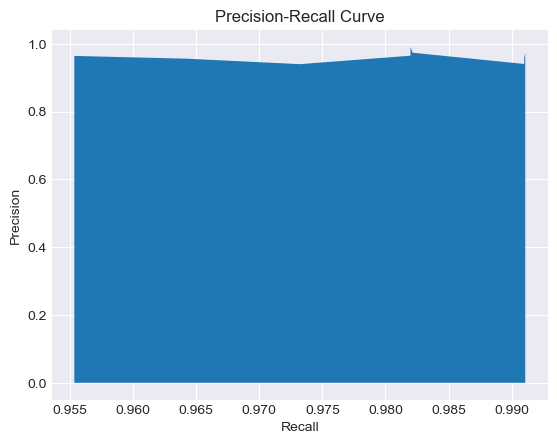

In [19]:
# https://www.datacamp.com/tutorial/precision-recall-curve-tutorial

plt.fill_between(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')